# Geospatial analysis with Yellow NY taxi data

Taxi zone shapefile is from http://www.nyc.gov/html/exit-page.html?url=https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip

In [1]:
import geopandas as gpd
import pysal as ps
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import datetime as dt
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pylab import figure, scatter, show
from matplotlib import colors


C:\Users\hyelim\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
taxi_zones = gpd.read_file('taxi_zones/taxi_zones.shp')
print(taxi_zones.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.9183527103 192536.0856972019,...  
1         Queens  (POLYGON ((1033269.243591294 172126.0078125, 1...  
2          Bronx  POLYGON ((1026308.769506663 256767.6975403726,...  
3      Manhattan  POLYGON ((992073.4667968601 203714.0759887695,...  
4  Staten Island  POLYGON ((935843.3104932606 144283.335850656, ...  


In [3]:
taxi_zones = taxi_zones.assign(PULocationID = lambda x: x.LocationID)
taxi_zones = taxi_zones.assign(DOLocationID = lambda x: x.LocationID)

To merge taxi zone geodata and yellow NY taxi data (March, June and November in 2017) I created two new columns named "PULocationID" and "DOLocationID" that already exist in the yellow NY taxi data. Since yellow NY taxi data is a huge file I selected randomly 10% of total data.

In [4]:
allFiles = glob.glob("*.csv")
frame = pd.DataFrame()
list_ = []

for file_ in allFiles:
    num_lines = sum(1 for l in open(file_))
    # Sample size - in this case ~10%
    size = int(num_lines / 10)

    skip_idx = random.sample(range(1, num_lines), num_lines - size)

    df = pd.read_csv(file_, skiprows=skip_idx, index_col=None, header=0 )
    list_.append(df)
    
yellow = pd.concat(list_)

According to the data dictionary I cleaned the data and made new colums: "pickup_hour", "pickup_day", "duration" and "before_tip". Since they are trip data, which were made by passenger a pick-up hour and day are more important than a drop-out hour and day. The "duration" value is trip duration on minutes and the "before_tip" value indicates the price displayed on the screen when a passenger was going to tip.

In [6]:
data = yellow[(yellow['passenger_count'] < 10) & 
                        (yellow['passenger_count'] > 0) & 
                        (yellow['extra'] >= 0) &
                        (yellow['extra'] <= 1) &
                        (yellow['RatecodeID'] < 7) &
                        (yellow['mta_tax'] >= 0) &
                        (yellow['tip_amount'] >= 0) &
                        (yellow['tolls_amount'] >= 0) &
                        (yellow['improvement_surcharge'] > 0) &
                        (yellow['total_amount'] >= 0)]

data = data.replace({'store_and_fwd_flag': {'Y': 1, 'N': 0}})

data['tpep_pickup_datetime'] = data.tpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['tpep_dropoff_datetime'] = data.tpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

data['pickup_hour'] = data.tpep_pickup_datetime.apply(lambda x: x.hour)
data['pickup_day'] = data.tpep_pickup_datetime.apply(lambda x: x.weekday())
data = data.assign(duration = lambda x: ((x.tpep_dropoff_datetime-x.tpep_pickup_datetime)/ np.timedelta64(1, 'm')))
data = data.assign(before_tip = lambda x: (x.total_amount-x.tip_amount))


Since I was going to see if there is some spatial relation with a tip payment, I selected only creditcard payment. 

In [7]:
tip_data = data[(data['payment_type'] == 1)]
tip_data = tip_data.drop(['payment_type'], axis=1)
tip_data = tip_data.drop(['passenger_count','pickup_hour','pickup_day','VendorID','tpep_pickup_datetime',
                          'tpep_dropoff_datetime','RatecodeID','store_and_fwd_flag',
                         'total_amount','extra','mta_tax','tolls_amount','improvement_surcharge'], axis=1)

Also, in the taxi payment screen to select a tip amount the options are presented as a percentage. So, I made a column "tip_percentage_2" that is a tip portion of "before_tip" value. In this analysis how much a passenger tipped was the important information, so I removed the data for trips with no tipping.

In [8]:
tip_data = tip_data.assign(tip_percentage_2 = lambda x: (x.tip_amount/(x.before_tip))*100)
tip_data['tip_no_paid'] = tip_data.tip_amount.isin([0]).astype(np.int64)
tip_data = tip_data[(tip_data['tip_no_paid'] == 0)]

# I selected only data inside 2.5 times of std of both variables: before trip and tip amout.
tip_data = tip_data[(np.abs(stats.zscore(tip_data[['before_tip','tip_amount']]))<2.5).all(axis=1)]


The two data sets were merged.

In [9]:
taxi_zones_tip_per = pd.merge(taxi_zones, pd.DataFrame(tip_data.groupby(['PULocationID'],as_index=False)
                                                       ['tip_percentage_2'].mean()).rename(index=str, 
                                                                                           columns={"tip_percentage_2": "PU_tip_per"}))
taxi_zones_tip_per = pd.merge(taxi_zones_tip_per, pd.DataFrame(tip_data.groupby(['DOLocationID'],
                                                    as_index=False)['tip_percentage_2'].mean()).rename(index=str, 
                                                                                            columns={"tip_percentage_2": "DO_tip_per"}))


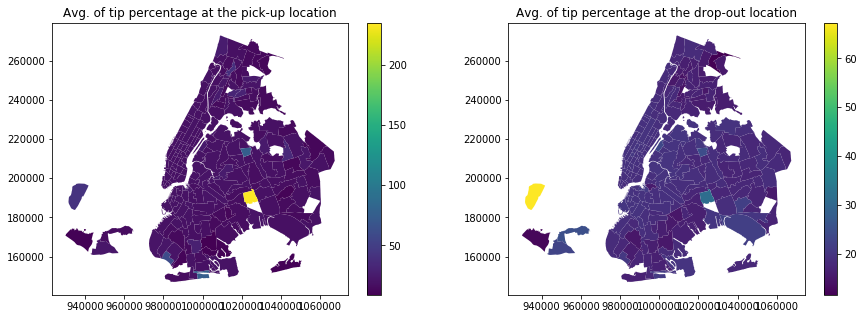

In [10]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

taxi_zones_tip_per.plot(column='PU_tip_per', cmap=None, legend=True, ax=ax[0])
taxi_zones_tip_per.plot(column='DO_tip_per', cmap=None, legend=True, ax=ax[1])

ax[0].set_title("Avg. of tip percentage at the pick-up location")
ax[1].set_title("Avg. of tip percentage at the drop-out location")


plt.show()

In [11]:
taxi_zones_tip = pd.merge(taxi_zones_tip_per, pd.DataFrame(tip_data.groupby(['PULocationID'],as_index=False)['tip_amount'].mean()).rename(index=str, columns={"tip_amount": "PU_tip"}))
taxi_zones_tip = pd.merge(taxi_zones_tip, pd.DataFrame(tip_data.groupby(['DOLocationID'],as_index=False)['tip_amount'].mean()).rename(index=str, columns={"tip_amount": "DO_tip"}))


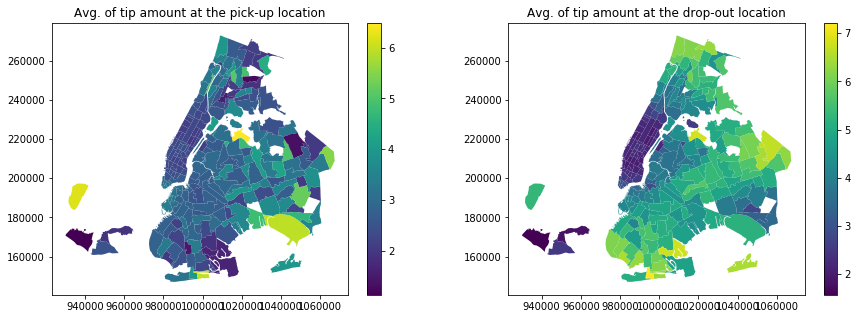

In [12]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

taxi_zones_tip.plot(column='PU_tip', cmap=None, legend=True, ax=ax[0])
taxi_zones_tip.plot(column='DO_tip', cmap=None, legend=True, ax=ax[1])

ax[0].set_title("Avg. of tip amount at the pick-up location")
ax[1].set_title("Avg. of tip amount at the drop-out location")


plt.show()

In [13]:
gdf = gpd.GeoDataFrame(taxi_zones_tip, geometry = taxi_zones_tip.geometry)
gdf.to_file(driver = 'ESRI Shapefile', filename= "taxi_zones_tip.shp")


# Is there a spatial relation for tip amounts?

I wanted to see if there is a spatial relation with a tip amount. Maybe passengers from some locations of NY would like to pay more of a tip than at other locations. 

In [14]:
data = ps.pdio.read_files("taxi_zones_tip.shp")
tx = gpd.read_file("taxi_zones_tip.shp")

centroids = np.array([list(poly.centroid) for poly in data.geometry])

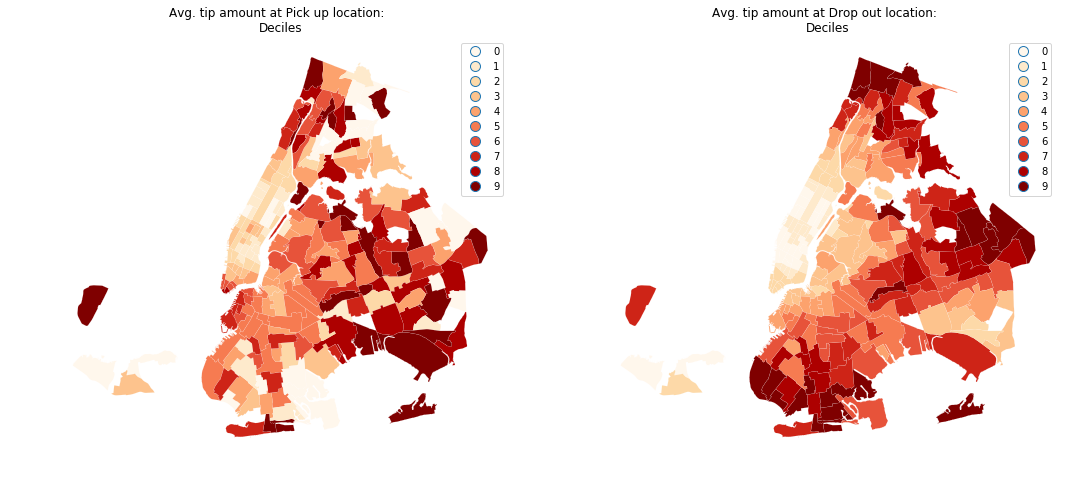

In [15]:
f, ax = plt.subplots(1, 2, figsize=(18, 9))

tx = gpd.read_file("taxi_zones_tip.shp")
PUtip10 = ps.Quantiles(data.PU_tip, k=10)
DOtip10 = ps.Quantiles(data.DO_tip, k=10)

tx.assign(cl=PUtip10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='OrRd', linewidth=0.1, ax=ax[0], 
        edgecolor='white', legend=True)
ax[0].set_axis_off()
ax[0].set_title("""Avg. tip amount at Pick up location:  
Deciles""")

tx.assign(cl=DOtip10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='OrRd', linewidth=0.1, ax=ax[1], 
        edgecolor='white', legend=True)
ax[1].set_axis_off()
ax[1].set_title("""Avg. tip amount at Drop out location:  
Deciles""")

plt.show()


Visual inspection of the map pattern for tip amount deciles allows us to search for spatial structure. If the spatial distribution of the amount was random, then we should not see any clustering of similar values on the map. However, the darker clusters was in the south west as well as the east in the case of the pick up location and in the north as well as the south in the case of the drop out location, and a concentration of the lighter hues (lower tip amount) nearby Manhattan.

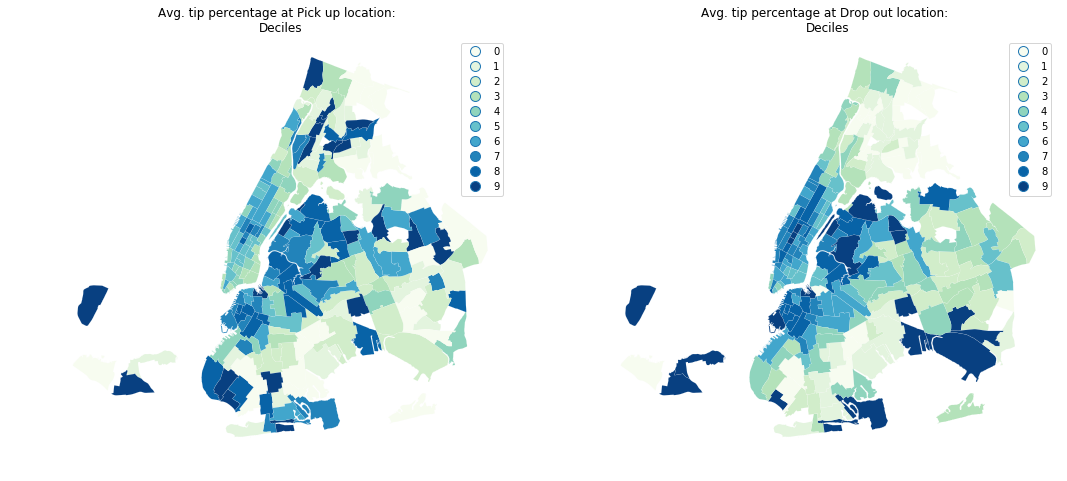

In [16]:
PUtipper10 = ps.Quantiles(data.PU_tip_per, k=10)
DOtipper10 = ps.Quantiles(data.DO_tip_per, k=10)


f, ax = plt.subplots(1, 2, figsize=(18, 9))



tx.assign(cl=PUtipper10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='GnBu', linewidth=0.1, ax=ax[0], 
        edgecolor='white', legend=True)
ax[0].set_axis_off()
ax[0].set_title("""Avg. tip percentage at Pick up location:  
Deciles""")

tx.assign(cl=DOtipper10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='GnBu', linewidth=0.1, ax=ax[1], 
        edgecolor='white', legend=True)
ax[1].set_axis_off()
ax[1].set_title("""Avg. tip percentage at Drop out location:  
Deciles""")

plt.show()


Visual inspection of the map pattern for tip percentage deciles allows us to search for a spatial structure but is a little bit more difficult. The darker clusters were concentrated in the center as well as some other locations in both cases, and a concentration of the lower tip percentage nearby Queens.

## Spatial Similarity

In [17]:
W = ps.queen_from_shapefile("taxi_zones_tip.shp")

C:\Users\hyelim\Anaconda3\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 4 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
C:\Users\hyelim\Anaconda3\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: 0, 94, 131, 170
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


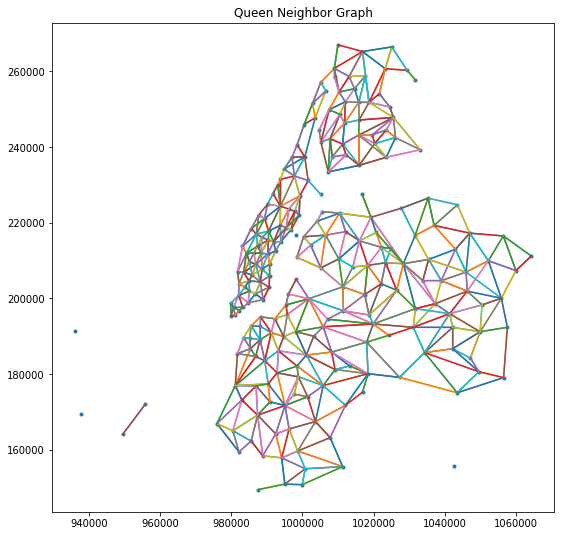

In [18]:
fig = figure(figsize=(9,9))

plt.plot(centroids[:,0], centroids[:,1],'.')

for k,neighs in W.neighbors.items():
    #print(k,neighs)
    origin = centroids[k]
    for neigh in neighs:
        segment = centroids[[k,neigh]]
        plt.plot(segment[:,0], segment[:,1], '-')
plt.title('Queen Neighbor Graph')
show()

## Attribute Similarity for Tip amount
- What we also need is a measure of attribute similarity to pair up with this concept of spatial similarity. The spatial lag is a derived variable that accomplishes this for us. 

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 94, ' is an island (no neighbors)')
('WARNING: ', 131, ' is an island (no neighbors)')
('WARNING: ', 170, ' is an island (no neighbors)')


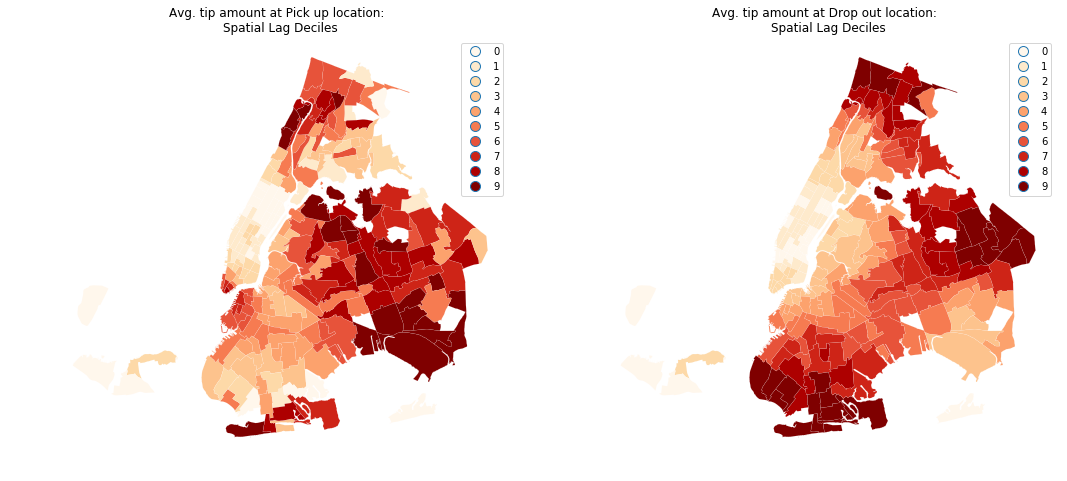

In [19]:
W.transform = 'r'

PUtipLag = ps.lag_spatial(W, data.PU_tip)
PUtipLagQ10 = ps.Quantiles(PUtipLag, k=10)
DOtipLag = ps.lag_spatial(W, data.DO_tip)
DOtipLagQ10 = ps.Quantiles(DOtipLag, k=10)


f, ax = plt.subplots(1, 2, figsize=(18, 9))

tx = gpd.read_file("taxi_zones_tip.shp")
PUtip10 = ps.Quantiles(data.PU_tip, k=10)
DOtip10 = ps.Quantiles(data.DO_tip, k=10)

tx.assign(cl=PUtipLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='OrRd', linewidth=0.1, ax=ax[0], 
        edgecolor='white', legend=True)
ax[0].set_axis_off()
ax[0].set_title("""Avg. tip amount at Pick up location:  
Spatial Lag Deciles""")

tx.assign(cl=DOtipLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='OrRd', linewidth=0.1, ax=ax[1], 
        edgecolor='white', legend=True)
ax[1].set_axis_off()
ax[1].set_title("""Avg. tip amount at Drop out location:  
Spatial Lag Deciles""")

plt.show()


The decile map for the spatial lag tends to enhance the impression of value similarity in space. However, it is difficult to see visually some association of tip amount with the tip amount of the spatial lag at NY.

In [20]:
PUtip = data.PU_tip
PUtip_b,PUtip_a = np.polyfit(PUtip, PUtipLag, 1)

DOtip = data.DO_tip
DOtip_b,DOtip_a = np.polyfit(DOtip, DOtipLag, 1)

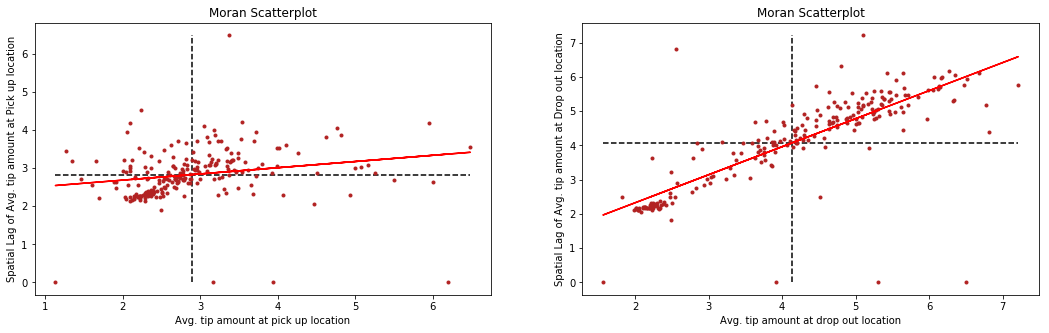

In [21]:
plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
plt.plot(PUtip, PUtipLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(PUtip.mean(), PUtipLag.min(), PUtipLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(PUtipLag.mean(), PUtip.min(), PUtip.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(PUtip, PUtip_a + PUtip_b*PUtip, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Avg. tip amount at Pick up location')
plt.xlabel('Avg. tip amount at pick up location')

plt.subplot(1,2,2)
plt.plot(DOtip, DOtipLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(DOtip.mean(), DOtipLag.min(), DOtipLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(DOtipLag.mean(), DOtip.min(), DOtip.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(DOtip,DOtip_a + DOtip_b*DOtip, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Avg. tip amount at Drop out location')
plt.xlabel('Avg. tip amount at drop out location')


plt.show()

## Global Spatial Autocorrelation for tip amount

In [22]:
I_PUtip = ps.Moran(data.PU_tip.values, W)
print("Global spatial autocorrelation for tip amount at pick up location")
print("Moran'I: ",I_PUtip.I, "p value: ", I_PUtip.p_sim)

I_DOtip = ps.Moran(data.DO_tip.values, W)
print("Global spatial autocorrelation for tip amount at drop out location")
print("Moran'I: ",I_DOtip.I, "p value: ", I_DOtip.p_sim)

Global spatial autocorrelation for tip amount at pick up location
Moran'I:  0.2170046160850224 p value:  0.001
Global spatial autocorrelation for tip amount at drop out location
Moran'I:  0.8402546677916656 p value:  0.001


- Moran'I statistic for a tip amount at pick up location is 0.2 for this data, and has a p value less than 1%.
- Moran'I statistic for a tip amount at drop out location is 0.8 for this data, and has a p value less than 1%.

The result of applying Moran's I is that we conclude there is a signficant spatial association in tip amounts.

## Local Spatial Autocorrelation for tip amount

In [23]:
LMo_PUtip = ps.Moran_Local(data.PU_tip.values, W, permutations=9999)
LMo_DOtip = ps.Moran_Local(data.DO_tip.values, W, permutations=9999)


C:\Users\hyelim\Anaconda3\lib\site-packages\pysal\esda\moran.py:861: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\hyelim\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\hyelim\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\hyelim\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In addition to the typical clustermap, we want to plot the statistically-significant LISA values in a different color than the others. To do this, first find all of the statistically significant LISAs. Since the $p$-values are in the same order as the $I_i$ statistics, we can do this in the following way:

In [24]:
PUtip_sigs = PUtip[LMo_PUtip.p_sim <= .001]
PUtip_W_sigs = PUtipLag[LMo_PUtip.p_sim <= .001]
PUtip_insigs = PUtip[LMo_PUtip.p_sim > .001]
PUtip_W_insigs = PUtipLag[LMo_PUtip.p_sim > .001]

DOtip_sigs = DOtip[LMo_DOtip.p_sim <= .001]
DOtip_W_sigs = DOtipLag[LMo_DOtip.p_sim <= .001]
DOtip_insigs = DOtip[LMo_DOtip.p_sim > .001]
DOtip_W_insigs = DOtipLag[LMo_DOtip.p_sim > .001]

Then, since we have a lot of points, we can plot the points with a statistically insignficant LISA value lighter using the alpha keyword. In addition, we would like to plot the statistically significant points in a dark red color.

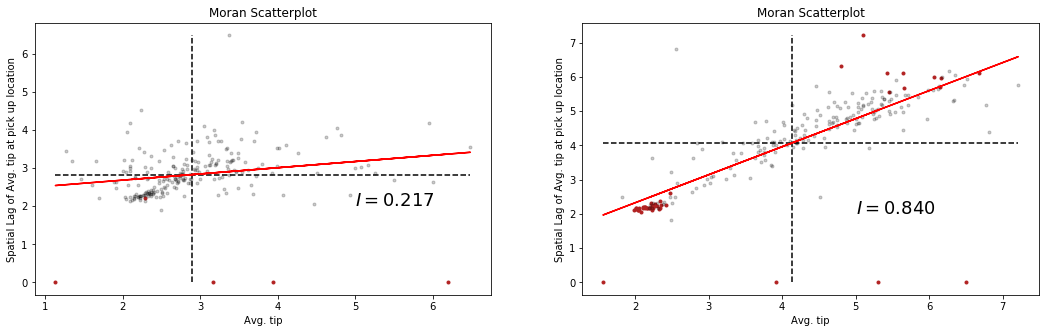

In [25]:
plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
plt.plot(PUtip_sigs, PUtip_W_sigs, '.', color='firebrick')
plt.plot(PUtip_insigs, PUtip_W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(PUtip.mean(), PUtipLag.min(), PUtipLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(PUtipLag.mean(), PUtip.min(), PUtip.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(PUtip, PUtip_a + PUtip_b*PUtip, 'r')
plt.text(s='$I = %.3f$' % I_PUtip.I, x=5, y=2, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Avg. tip at pick up location')
plt.xlabel('Avg. tip')

plt.subplot(1,2,2)
plt.plot(DOtip_sigs, DOtip_W_sigs, '.', color='firebrick')
plt.plot(DOtip_insigs, DOtip_W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(DOtip.mean(), DOtipLag.min(), DOtipLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(DOtipLag.mean(), DOtip.min(), DOtip.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(DOtip, DOtip_a + DOtip_b*DOtip, 'r')
plt.text(s='$I = %.3f$' % I_DOtip.I, x=5, y=2, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Avg. tip at pick up location')
plt.xlabel('Avg. tip')
plt.show()

In [26]:
PUtip_sig = LMo_PUtip.p_sim < 0.05
LMo_PUtip_sig = LMo_PUtip.p_sim < 0.05
PUtip_hotspots = LMo_PUtip.q==1 * PUtip_sig
PUtip_coldspots = LMo_PUtip.q==3 * PUtip_sig

DOtip_sig = LMo_DOtip.p_sim < 0.05
LMo_DOtip_sig = LMo_DOtip.p_sim < 0.05
DOtip_hotspots = LMo_DOtip.q==1 * DOtip_sig
DOtip_coldspots = LMo_DOtip.q==3 * DOtip_sig


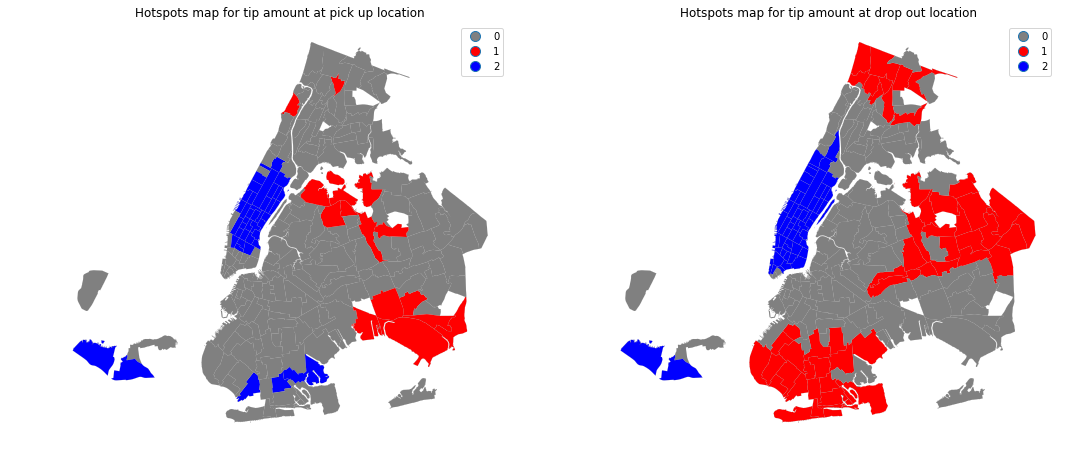

In [27]:
hcmap = colors.ListedColormap(['grey', 'red','blue'])

f, ax = plt.subplots(1,2, figsize=(18, 9))

PUtip_hotcold = PUtip_hotspots*1 + PUtip_coldspots*2
tx.assign(cl=PUtip_hotcold).plot(column='cl', categorical=True, 
        k=2, cmap=hcmap, linewidth=0.1, ax=ax[0], 
        edgecolor='grey', legend=True)
ax[0].set_axis_off()
ax[0].set_title('Hotspots map for tip amount at pick up location')


DOtip_hotcold = DOtip_hotspots*1 + DOtip_coldspots*2
tx.assign(cl=DOtip_hotcold).plot(column='cl', categorical=True, 
        k=2, cmap=hcmap, linewidth=0.1, ax=ax[1], 
        edgecolor='grey', legend=True)
ax[1].set_axis_off()
ax[1].set_title('Hotspots map for tip amount at drop out location')


plt.show()

Where tip amounts have a high value and be surrounded by other location with high values as well like.
- High tip amount at pick up: the northern and southern Queens, Spuyten Duyvil/Kingsbridge in the Bronx and Inwood Manhattan
- Low tip amount at pick up: Far Rockaway in the Queens, Eltingville/Annadale/Prince's Bay in the Staten Island, the almost Manhattan, and East Concourse/Concourse Village, Mount Hope, Fordham South and Belmont in the Bronx 

- High tip amount at drop out: The south Brooklyn, the almos Queens, and the Bronx
- Low tip amount at drop out: the most Manhattan and Eltingville/Annadale/Prince's Bay in the Staten Island

## Attribute Similarity for Tip percentage

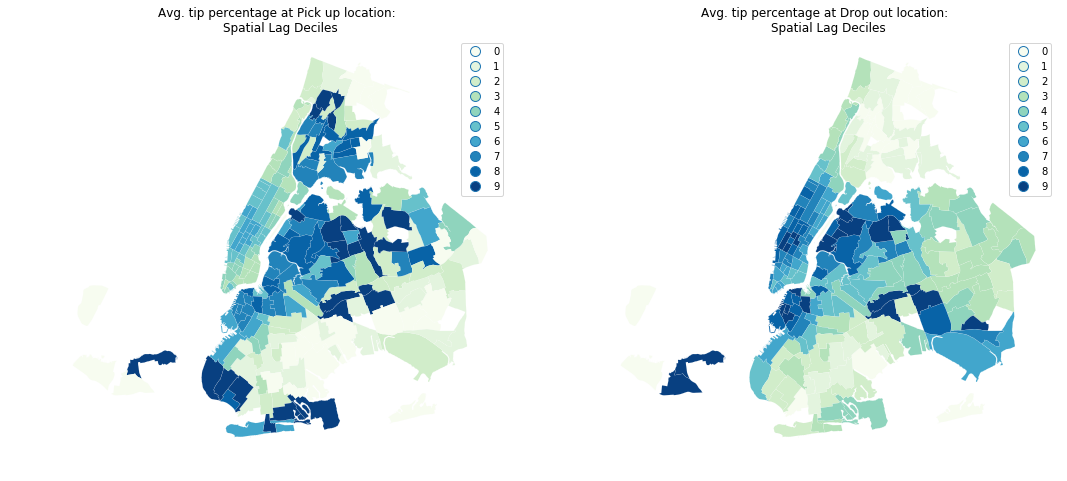

In [28]:
PUtip_perLag = ps.lag_spatial(W, data.PU_tip_per)
PUtip_perLagQ10 = ps.Quantiles(PUtip_perLag, k=10)
DOtip_perLag = ps.lag_spatial(W, data.DO_tip_per)
DOtip_perLagQ10 = ps.Quantiles(DOtip_perLag, k=10)


f, ax = plt.subplots(1, 2, figsize=(18, 9))

tx = gpd.read_file("taxi_zones_tip.shp")
PUtip_per10 = ps.Quantiles(data.PU_tip_per, k=10)
DOtip_per10 = ps.Quantiles(data.DO_tip_per, k=10)

tx.assign(cl=PUtip_perLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='GnBu', linewidth=0.1, ax=ax[0], 
        edgecolor='white', legend=True)
ax[0].set_axis_off()
ax[0].set_title("""Avg. tip percentage at Pick up location:  
Spatial Lag Deciles""")

tx.assign(cl=DOtip_perLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='GnBu', linewidth=0.1, ax=ax[1], 
        edgecolor='white', legend=True)
ax[1].set_axis_off()
ax[1].set_title("""Avg. tip percentage at Drop out location:  
Spatial Lag Deciles""")

plt.show()

In [29]:
PUtip_per = data.PU_tip_per
PUtip_per_b,PUtip_per_a = np.polyfit(PUtip_per, PUtip_perLag, 1)

DOtip_per = data.DO_tip_per
DOtip_per_b,DOtip_per_a = np.polyfit(DOtip_per, DOtip_perLag, 1)

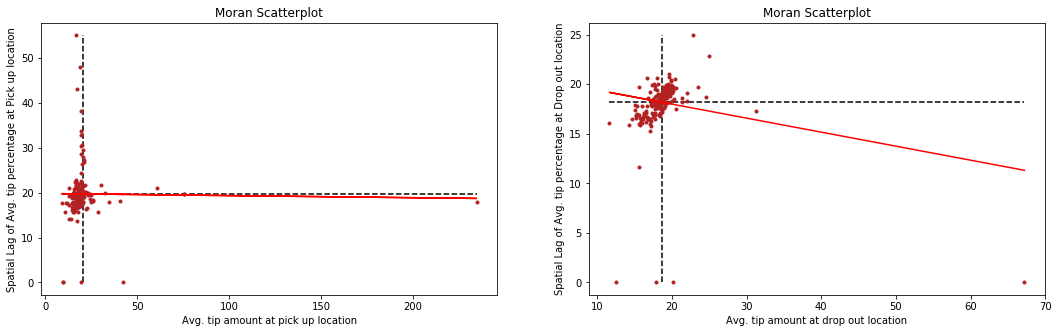

In [30]:
plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
plt.plot(PUtip_per, PUtip_perLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(PUtip_per.mean(), PUtip_perLag.min(), PUtip_perLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(PUtip_perLag.mean(), PUtip_per.min(), PUtip_per.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(PUtip_per, PUtip_per_a + PUtip_per_b*PUtip_per, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Avg. tip percentage at Pick up location')
plt.xlabel('Avg. tip amount at pick up location')

plt.subplot(1,2,2)
plt.plot(DOtip_per, DOtip_perLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(DOtip_per.mean(), DOtip_perLag.min(), DOtip_perLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(DOtip_perLag.mean(), DOtip_per.min(), DOtip_per.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(DOtip_per,DOtip_per_a + DOtip_per_b*DOtip_per, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Avg. tip percentage at Drop out location')
plt.xlabel('Avg. tip amount at drop out location')


plt.show()

## Global Spatial Autocorrelation for tip percentage

In [31]:
I_PUtip_per = ps.Moran(data.PU_tip_per.values, W)
print("Global spatial autocorrelation for tip percentage at pick up location")
print("Moran'I: ",I_PUtip_per.I, "p value: ", I_PUtip_per.p_sim)

I_DOtip_per = ps.Moran(data.DO_tip_per.values, W)
print("Global spatial autocorrelation for tip percentage at drop out location")
print("Moran'I: ",I_DOtip_per.I, "p value: ", I_DOtip_per.p_sim)

Global spatial autocorrelation for tip percentage at pick up location
Moran'I:  -0.005255842298134443 p value:  0.39
Global spatial autocorrelation for tip percentage at drop out location
Moran'I:  0.11274216545202304 p value:  0.005


- Moran'I statistic for a tip percentage at pick up location is -0.005 for this data but it's not significant.
- Moran'I statistic for a tip percentage at drop out location is 0.11 for this data, and has a p value less than 1%.

The result of applying Moran's I for a tip percentage at drop out location is that we conclude there is a significant spatial association.

## Local Spatial Autocorrelation for tip percentage

In [32]:
LMo_DOtip_per = ps.Moran_Local(data.DO_tip_per.values, W, permutations=9999)


C:\Users\hyelim\Anaconda3\lib\site-packages\pysal\esda\moran.py:861: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\hyelim\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\hyelim\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\hyelim\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [33]:
DOtip_per_sigs = DOtip_per[LMo_DOtip_per.p_sim <= .001]
DOtip_per_W_sigs = DOtip_perLag[LMo_DOtip_per.p_sim <= .001]
DOtip_per_insigs = DOtip_per[LMo_DOtip_per.p_sim > .001]
DOtip_per_W_insigs = DOtip_perLag[LMo_DOtip_per.p_sim > .001]

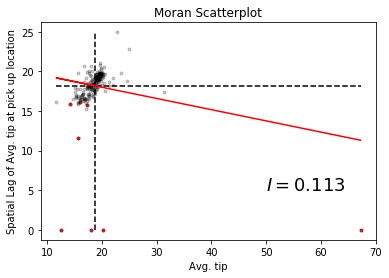

In [36]:
plt.plot(DOtip_per_sigs, DOtip_per_W_sigs, '.', color='firebrick')
plt.plot(DOtip_per_insigs, DOtip_per_W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(DOtip_per.mean(), DOtip_perLag.min(), DOtip_perLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(DOtip_perLag.mean(), DOtip_per.min(), DOtip_per.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(DOtip_per, DOtip_per_a + DOtip_per_b*DOtip_per, 'r')
plt.text(s='$I = %.3f$' % I_DOtip_per.I, x=50, y=5, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Avg. tip at pick up location')
plt.xlabel('Avg. tip')
plt.show()

plt.show()

In [37]:
DOtip_per_sig = LMo_DOtip_per.p_sim < 0.05
LMo_DOtip_per_sig = LMo_DOtip_per.p_sim < 0.05
DOtip_per_hotspots = LMo_DOtip_per.q==1 * DOtip_per_sig
DOtip_per_coldspots = LMo_DOtip_per.q==3 * DOtip_per_sig

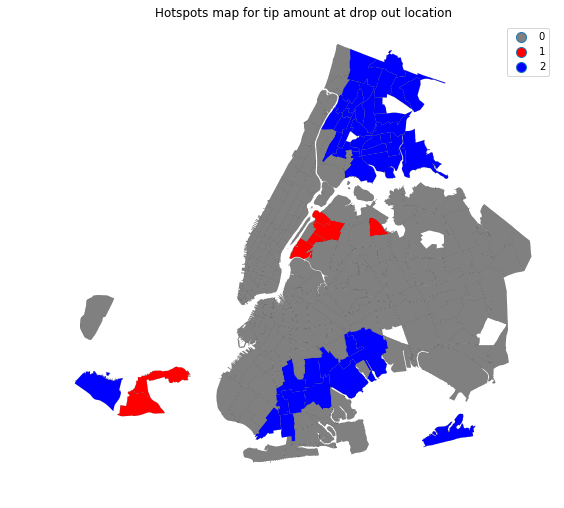

In [38]:
hcmap = colors.ListedColormap(['grey', 'red','blue'])
hotcold = DOtip_per_hotspots*1 + DOtip_per_coldspots*2
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=hotcold).plot(column='cl', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
ax.set_title('Hotspots map for tip amount at drop out location')
plt.show()

- High tip percentage at Drop out: Westerleigh in the Staten Island, Old Astoria, Long Island City/Hunters Point and Long Island City/Queens Plaza in the Queens.
- Low tip percentage at Drop out: the South Brooklyn, Far Roclaway and Queens Village in the Queens

## Conclusion

- In the case of an geospatial analysis for a tip amount, there is a some spatial relationship. 
- It would be interesting to make a further analysis like makig a model using the other variables like a trip distance, trip duration as well as a spatial concentration of turists (e.g. credit card's use data).
- Tip percentage has a such little spatial relation. I think in this case passengers had faced a screen with the three options when they were going to tip, the majority made a decision to choose among them. So, the distribution of tip percentage seems like a homogeneous.